In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping

In [155]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

df = pd.read_csv('sf_dataset.csv', parse_dates=['date'], index_col=['date', 'time'])
# df = df.drop([
#     # 'time',
#     # 'date',
#     # 'pvsim',
#     'Lag_24',
#     'Lag_25',
#     'Lag_48',
#     'Lag_72',
#     'solar_azimuth',
#     'solar_zenith',
#     'solar_elevation',
#     'solar_time',
# 
#     'shortwave_radiation',  #
#     'direct_radiation', #
#     'diffuse_radiation', #
#     'direct_normal_irradiance', #
# 
#     'weathercode',
# 
#     'temperature_2m', #
#     'dewpoint_2m',
# 
#     'relativehumidity_2m',
#     'surface_pressure',
# 
#     'windspeed_10m',
#     'winddirection_10m',
# 
#     'cloudcover', #
#     'cloudcover_low',
#     'cloudcover_mid',
#     'cloudcover_high',
#     'cloud_radiation',
# 
#     'precipitation',
#     'rain',
#     'snowfall',
# ], axis=1)
power = df.pop('Power')
df['Power'] = power
print(df.shape)
print(df.columns)

(12816, 29)
Index(['solar_azimuth', 'solar_zenith', 'solar_elevation', 'solar_time',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance', 'temperature_2m', 'dewpoint_2m',
       'relativehumidity_2m', 'surface_pressure', 'windspeed_10m',
       'winddirection_10m', 'cloudcover', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'precipitation', 'rain', 'snowfall', 'weathercode',
       'cloud_radiation', 'pvsim', 'Lag_24', 'Lag_25', 'Lag_48', 'Lag_72',
       'Power'],
      dtype='object')


In [156]:
train_df = df[df.index.get_level_values('date') < '2023-02-01'] 
test_df = df[df.index.get_level_values('date') >= '2023-02-01']

# print(train_df.tail(1))
print(test_df.columns)
print(test_df.shape)

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

data_scaled = pd.concat([train_scaled,test_scaled],axis=0)

print(data_scaled.shape)
# train_scaled.head()
# train_df_sc = scaler.transform(train_df)
# test_df_sc = scaler.transform(test_df)

Index(['solar_azimuth', 'solar_zenith', 'solar_elevation', 'solar_time',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance', 'temperature_2m', 'dewpoint_2m',
       'relativehumidity_2m', 'surface_pressure', 'windspeed_10m',
       'winddirection_10m', 'cloudcover', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'precipitation', 'rain', 'snowfall', 'weathercode',
       'cloud_radiation', 'pvsim', 'Lag_24', 'Lag_25', 'Lag_48', 'Lag_72',
       'Power'],
      dtype='object')
(3312, 29)
(12816, 29)


In [157]:
look_back = 15*24
horizon = 24
# print(train_scaled.shape[0])

In [158]:
def prepare_data(data, frame_size, shots):
    X, y = [], []
    for i in range(0, data.shape[0], shots):
        end_ix = i + shots + frame_size
        if end_ix > data.shape[0]:
            break
        X.append(data.iloc[i:end_ix, :].to_numpy()) 
        y.append(data.iloc[end_ix-shots:end_ix, -1].to_numpy())
    return np.array(X), np.array(y)

In [159]:
x_data,y_data= prepare_data(data_scaled,look_back,horizon)
print(x_data.shape)

X_train = x_data[:380,:,:] 
y_train = y_data[:380,]

print(X_train.shape)
print(y_train.shape)

X_test = x_data[380:,:,:] 
y_test = y_data[380:,]

print(X_test.shape)
print(y_test.shape)


(519, 384, 29)
(380, 384, 29)
(380, 24)
(139, 384, 29)
(139, 24)


In [160]:
# X_train, y_train = prepare_data(train_scaled, look_back, horizon)
# X_train.shape

In [161]:
# X_test, y_test = prepare_data(test_scaled, look_back, horizon)

X_train[:, -24:, -1] = 0
X_test[:, -24:, -1] = 0

In [162]:
# print(y_train[50,:])
# print(y_train[10,:])

In [163]:
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

In [164]:
# class Attention(tf.keras.layers.Layer):
#     def __init__(self, units):
#         super(Attention, self).__init__()
#         self.W = tf.keras.layers.Dense(units)
#         self.V = tf.keras.layers.Dense(1)
# 
#     def call(self, inputs):
#         score = tf.nn.tanh(self.W(inputs))
#         attention_weights = tf.nn.softmax(self.V(score), axis=1)
#         context_vector = attention_weights * inputs
#         context_vector = tf.reduce_sum(context_vector, axis=1)
#         return context_vector

In [165]:
class ImprovedAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(ImprovedAttention, self).__init__()
        self.W_q = tf.keras.layers.Dense(units)
        self.W_k = tf.keras.layers.Dense(units)
        self.W_v = tf.keras.layers.Dense(units)
        self.W_o = tf.keras.layers.Dense(units)
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, inputs, mask=None, return_attention_weights=False):
        q = self.W_q(inputs)
        k = self.W_k(inputs)
        v = self.W_v(inputs)

        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # if mask is not None:
        #     scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        output = self.W_o(output)
        
        if return_attention_weights:
            return self.layer_norm(output), attention_weights  # Return output and attention weights  + inputs
        return output #self.layer_norm(output)  # Residual connection    + inputs


In [166]:
def build_attention_visualization_model(T, D):
    inputs = Input(shape=(T, D))
    x = Bidirectional(LSTM(50, return_sequences=True))(inputs)
    attention_output, attention_weights = ImprovedAttention(100)(x, return_attention_weights=True)
    model = Model(inputs=inputs, outputs=[attention_output, attention_weights])
    return model

In [167]:
def plot_attention_weights(model, input_sample, epoch):
    _, attention_weights = model.predict(input_sample)
    attention_weights = attention_weights[0]  
    plt.figure(figsize=(10, 10))
    sns.heatmap(attention_weights, cmap="viridis")
    plt.title(f"Attention Weights, epoch={epoch}")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.show()

In [168]:
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, Flatten, Attention

def build_model(T, D):
    inputs = Input(shape=(T, D))
    x = Bidirectional(LSTM(50, return_sequences=True))(inputs)
    x = ImprovedAttention(100)(x) 
    x = GlobalAveragePooling1D()(x)
    x = Dense(120)(x)
    x = Dense(60)(x)
    x = Dense(120)(x)
    x = Dense(60)(x)
    x = Dense(24)(x)
    model = Model(inputs=inputs, outputs=x)
    return model

# att_layer = Attention(use_scale=True)([input_layer2, input_layer2])


In [169]:
# def build_model2(T, D):
#     inputs = Input(shape=(T, D))
#     x = LSTM(50, return_sequences=True)(inputs) 
#     x = LSTM(50, return_sequences=False)(x)
#     x = Dense(120)(x)
#     x = Dense(60)(x)
#     x = Dense(120)(x)
#     x = Dense(60)(x)
#     x = Dense(24)(x)
#     model = Model(inputs=inputs, outputs=x)
#     return model

In [170]:
from keras.optimizers import Adam
model = build_model(look_back+horizon, X_train.shape[2])
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
epochs = 300
# learning_rate = 5e-4
# decay_rate = learning_rate / epochs  
# adam_optimizer = Adam(learning_rate=learning_rate)
# model.compile(optimizer=adam_optimizer, loss="mse")
model.compile(optimizer="adam", loss="mse")
# epochs = 100
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2)  # , callbacks=[early_stopping]

Epoch 1/300
10/10 [==============================] - 9s 374ms/step - loss: 0.0452 - val_loss: 0.0144
Epoch 2/300
10/10 [==============================] - 2s 227ms/step - loss: 0.0191 - val_loss: 0.0038
Epoch 3/300
10/10 [==============================] - 2s 226ms/step - loss: 0.0154 - val_loss: 0.0039
Epoch 4/300
10/10 [==============================] - 2s 210ms/step - loss: 0.0143 - val_loss: 0.0021
Epoch 5/300
10/10 [==============================] - 2s 197ms/step - loss: 0.0148 - val_loss: 0.0023
Epoch 6/300
10/10 [==============================] - 2s 199ms/step - loss: 0.0140 - val_loss: 0.0037
Epoch 7/300
10/10 [==============================] - 2s 231ms/step - loss: 0.0137 - val_loss: 0.0021
Epoch 8/300
10/10 [==============================] - 2s 227ms/step - loss: 0.0137 - val_loss: 0.0019
Epoch 9/300
10/10 [==============================] - 2s 227ms/step - loss: 0.0133 - val_loss: 0.0021
Epoch 10/300
10/10 [==============================] - 2s 225ms/step - loss: 0.0143 - val_lo

In [171]:
 # model2 = build_model2(look_back+horizon, X_train.shape[2])
# # early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
# model2.compile(optimizer="adam", loss="mse")
# history2 = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)  # , callbacks=[early_stopping]

In [191]:
y_pred = model.predict(X_test)
y_pred[y_pred<0]= 0
y_pred[y_test==0]=0
y_test = np.squeeze(y_test)
indices = np.nonzero(y_test)[0]
y_test_nz = y_test [indices]
y_pred_nz = y_pred [indices]

5/5 [==============================] - 1s 112ms/step


In [192]:
y_pred_tf= y_pred[1:,:]
y_pred_shp  = y_pred_tf.reshape(-1,1)
print(y_pred_shp.shape)

result_df= test_scaled.copy()
print(result_df.columns)
result_df['Power'] = y_pred_shp
preds = scaler.inverse_transform(result_df)[:, -1]


(3312, 1)
Index(['solar_azimuth', 'solar_zenith', 'solar_elevation', 'solar_time',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance', 'temperature_2m', 'dewpoint_2m',
       'relativehumidity_2m', 'surface_pressure', 'windspeed_10m',
       'winddirection_10m', 'cloudcover', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'precipitation', 'rain', 'snowfall', 'weathercode',
       'cloud_radiation', 'pvsim', 'Lag_24', 'Lag_25', 'Lag_48', 'Lag_72',
       'Power'],
      dtype='object')


In [193]:
def mean_absolute_percentage(y_true, y_pred):
    ymean = np.mean(y_true)
    ape = [abs(y_true[i] - y_pred[i]) for i in range(len(y_true))]
    mape = (sum(ape) / len(y_true)) * 100
    mape = mape / ymean
    return mape

In [194]:
print('pvsim performance:')
print('\tnRmse:', mean_squared_error(test_df['Power'].values, test_df['pvsim'].values, squared=True)/np.max(test_df['Power'].values))
print('\tMAPE:', np.mean(mean_absolute_percentage(test_df['Power'].values, test_df['pvsim'].values)))
print('\tnMAE:',  mean_absolute_error(test_df['Power'].values, test_df['pvsim'].values)/np.max(test_df['Power']))
print('\tR2:',   r2_score(test_df['Power'].values, test_df['pvsim'].values))

test performance:
	nRmse: 203.34438796950673
	MAPE: 28.498037489308487
	nMAE: 0.046237506392853275
	R2: 0.8711680017710494


In [195]:
print('ml performance:')
print('\tnRmse:', mean_squared_error(test_df['Power'].values, preds, squared=True)/np.max(test_df['Power'].values))
print('\tMAPE:', np.mean(mean_absolute_percentage(test_df['Power'], preds)))
print('\tnMAE:',  mean_absolute_error(test_df['Power'], preds)/np.max(test_df['Power']))
print('\tR2:',   r2_score(test_df['Power'], preds))

indices = np.nonzero(test_df['Power'])[0]
act_nz = test_df['Power'][indices]
preds_nz = preds[indices]

print('ml_nz performance:')
print('\tnRmse:', mean_squared_error(act_nz, preds_nz, squared=True)/np.max(act_nz))
print('\tMAPE:', np.mean(mean_absolute_percentage(act_nz, preds_nz)))
print('\tnMAE:',  mean_absolute_error(act_nz, preds_nz)/np.max(act_nz))
print('\tR2:',   r2_score(act_nz, preds_nz))

test performance:
	nRmse: 222.8647085292366
	MAPE: 28.160225324762568
	nMAE: 0.04568941278733286
	R2: 0.8588005992137838
test performance:
	nRmse: 404.67539180308745
	MAPE: 28.160225324762557
	nMAE: 0.08296235479805177
	R2: 0.7854492664470402


C:\Users\Hossein\AppData\Local\Temp\ipykernel_20920\1737368977.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ape = [abs(y_true[i] - y_pred[i]) for i in range(len(y_true))]
C:\Users\Hossein\AppData\Local\Temp\ipykernel_20920\2829941858.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  act_nz = test_df['Power'][indices]
C:\Users\Hossein\AppData\Local\Temp\ipykernel_20920\1737368977.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

In [196]:
print(preds)

[0. 0. 0. ... 0. 0. 0.]


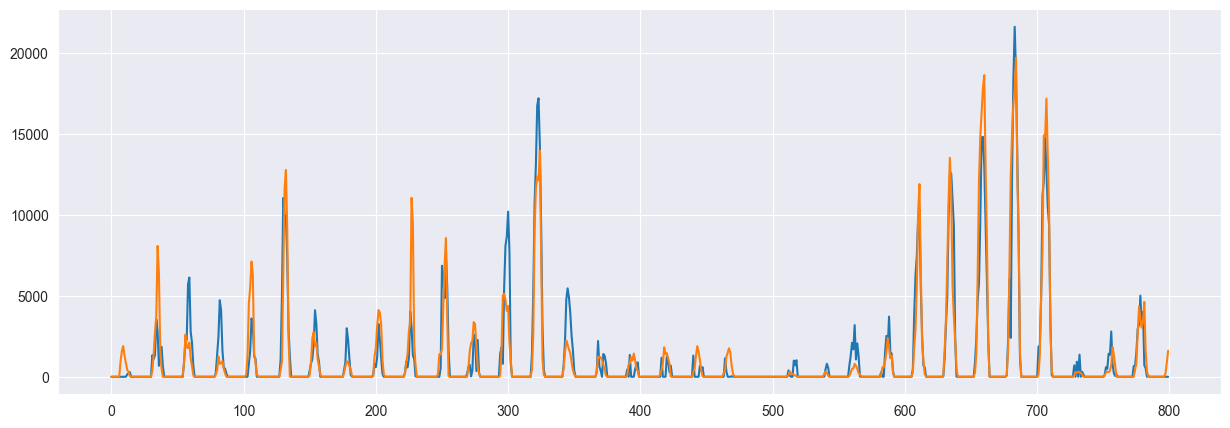

In [201]:
fig = plt.figure(figsize=(15,5))
plt.plot(preds[:800])
plt.plot(test_df['Power'].values[:800])
plt.show()

In [179]:
# np.max(y_test_nz)

In [1]:
print('test performance:')
print('\tRmse:', mean_squared_error(y_test_nz, y_pred_nz, squared=True))
print('\tMAPE:', np.mean(mean_absolute_percentage(y_test_nz, y_pred_nz)))
print('\tMAE:',  mean_absolute_error(y_test_nz, y_pred_nz))
print('\tR2:',   r2_score(y_test_nz, y_pred_nz))

# r2score = []    
# for i in range(np.shape(y_pred)[0]):
#      r2score.append(r2_score(y_pred[i,:], y_test[i,:]))
# print('\tR2:', np.mean(r2score))

test performance:


NameError: name 'mean_squared_error' is not defined

In [181]:
# y_pred2 = model2.predict(X_test)
# y_pred[y_pred<0]= 0
# y_pred[y_test==0]=0
# # y_test = np.squeeze(y_test)
# 
# # indices = np.nonzero(y_test)[0]
# 
# # y_test_nz = y_test [indices]
# y_pred_nz2 = y_pred2 [indices]

In [182]:
# print('test performance:')
# print('\tRmse:', mean_squared_error(y_test_nz, y_pred_nz2, squared=True))
# print('\tMAPE:', np.mean(mean_absolute_percentage(y_test_nz, y_pred_nz2)))
# print('\tMAE:', mean_absolute_error(y_test_nz, y_pred_nz2))
# # print('\tr2:', r2_score(y_test_nz, y_pred_nz))
# 
# r2score = []    
# for i in range(np.shape(y_pred2)[0]):
#      r2score.append(r2_score(y_pred2[i,:], y_test[i,:]))
# print('\tR2:', np.mean(r2score))

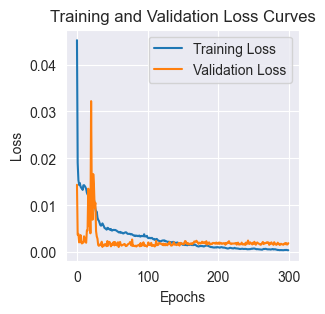

In [183]:
plt.figure(figsize=(3, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [184]:
# plt.figure(figsize=(3, 3))
# plt.plot(history2.history['loss'], label='Training Loss')
# plt.plot(history2.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss Curves')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [185]:
# # print(y_test.shape)
# # print(y_pred.shape)
# 
# X_pred=X_test
# for i in range(X_test.shape[0]):
#     X_test[i,-24:, -1] = y_test[i,:]
#     X_pred[i,-24:, -1] = y_pred[i,:]
# 
# print(X_test.shape)
# print(X_pred.shape)
# 
# X_test_nw = [] 
# X_pred_nw = []
# for i in range(0, X_test.shape[0], 24):
#     X_test_nw[i,:] = X_test[i,:24, :]
#     X_pred_nw[i,:] = X_pred[i,:24, :]
#     
# # X_test = scaler.inverse_transform(X_test[-1,-24:,:])
# # X_pred = scaler.inverse_transform(X_pred[-1,-24:,:])
# 
# X_test_sc = scaler.inverse_transform(X_test_nw)
# X_pred_sc = scaler.inverse_transform(X_pred_nw)
# 
# # for i in range(X_test.shape[0]):
# #     y_test[i,:] = X_test[i,-24:, -1]
# #     y_pred[i,:] = X_pred[i,-24:, -1]

In [186]:
# y_test.shape

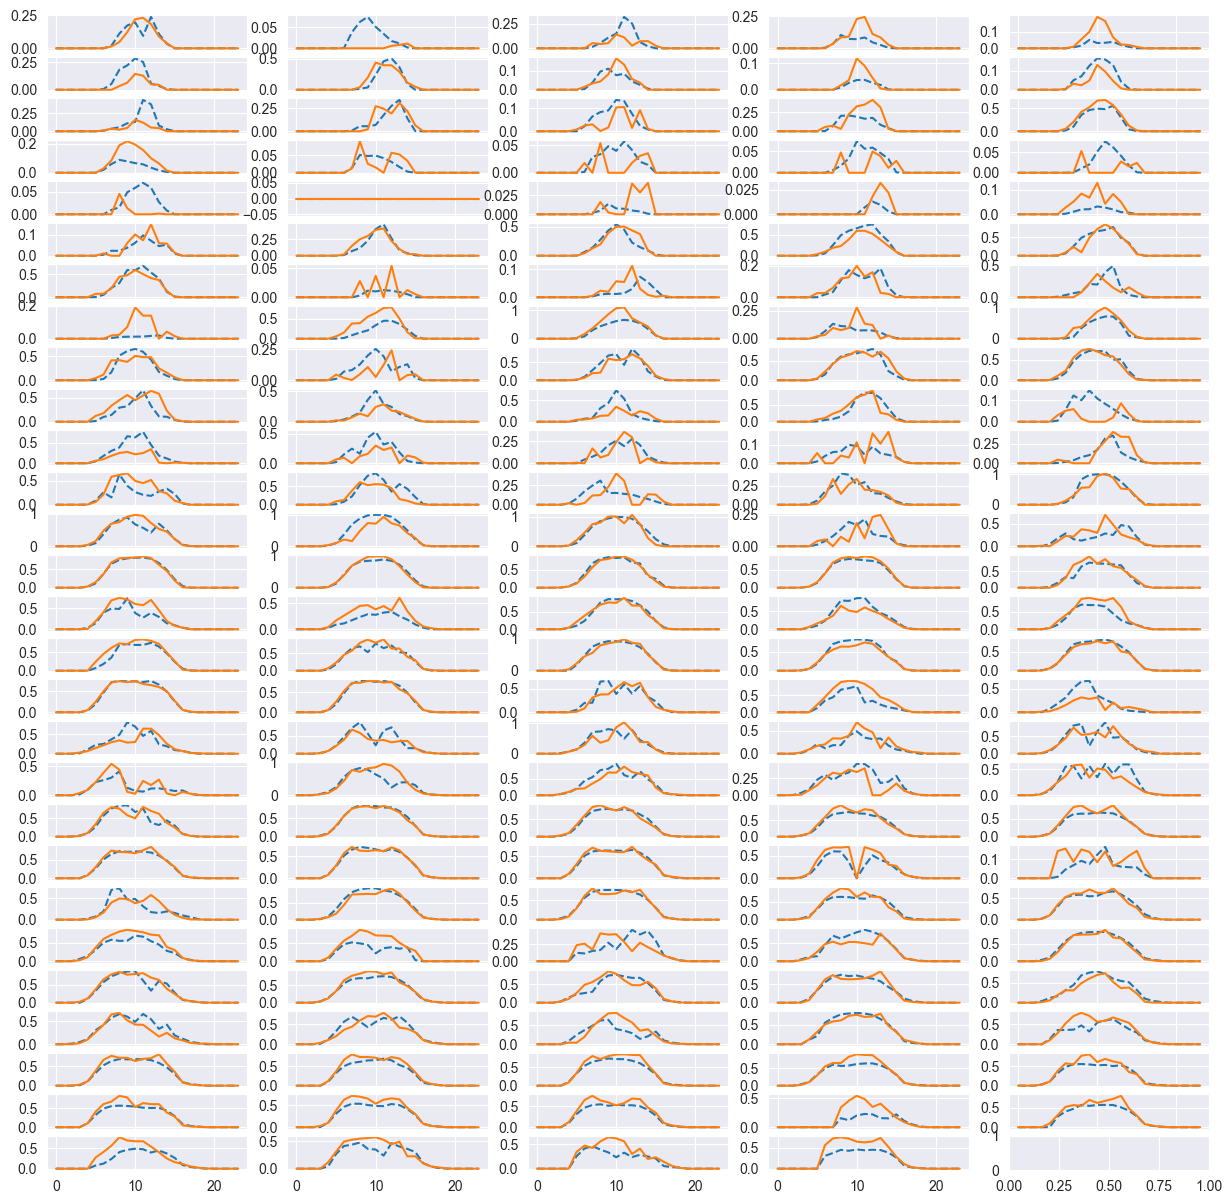

In [200]:
fig,ax=plt.subplots(28,5, figsize=(15,15))
for num in range(y_test.shape[0]):
    i,j = divmod(num,5) 
    ax[i,j].plot(y_test[num,:], '--', label='actual')
    ax[i,j].plot(y_pred[num,:], label='prediction')
    # ax[i,j].legend()
    # ax[i,j].plot(y_pred2[i,:], label='prediction2')
# plt.tight_layout()
plt.show()

In [188]:
vis_model = build_attention_visualization_model(look_back+horizon, X_train.shape[2])

In [189]:
print(X_test.shape)
X_test[10,:,:].shape

(139, 384, 29)


(384, 29)

5/5 [==============================] - 1s 81ms/step


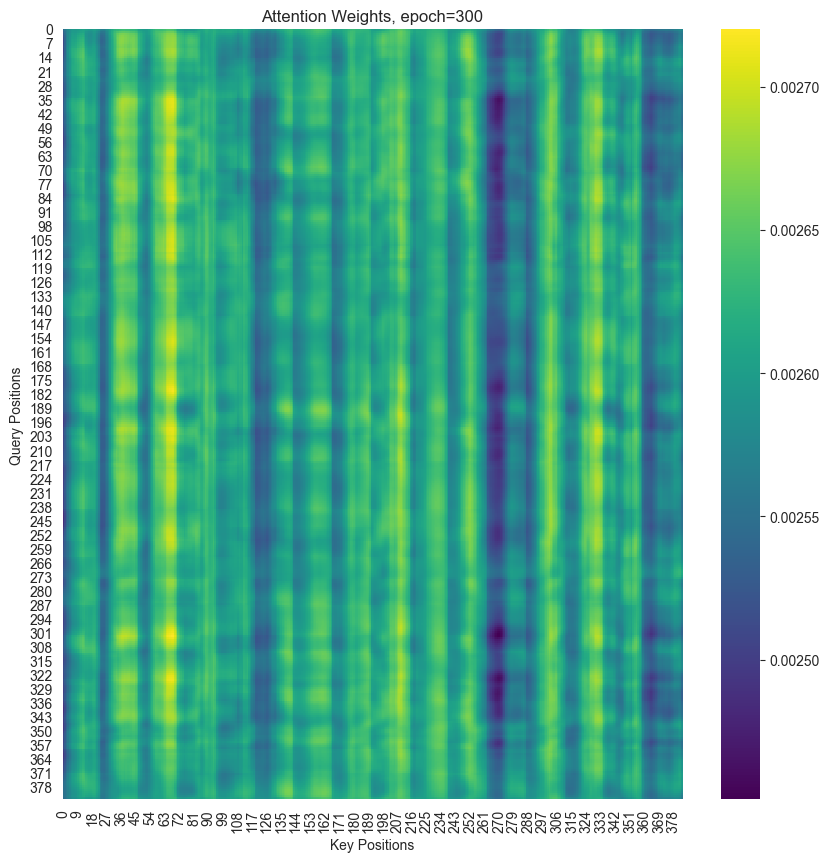

In [190]:
plot_attention_weights(vis_model, X_test, epoch= epochs)